In [1]:

# ESPN
from espn_api.basketball import League
from espn_api.basketball import Player

# basketball-reference
from basketball_reference_web_scraper import client

# Connection to my DB
import mysql.connector as mysql
from mysql.connector import Error


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.ticker as mtick
import seaborn as sn

from datetime import datetime
from datetime import date
from datetime import timedelta


## Preliminaries, set ups & initiators 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


exec(open('/Users/franciscoavalosjr/Desktop/basketball-creds.py').read())


In [2]:
league=League(league_id=leagueid, 
				year=2023,
				espn_s2=espn_s2,
				swid=swid, 
				debug=False)

In [3]:
connection=mysql.connect(host=sports_db_admin_host,
                        database=sports_db_admin_db,
                        user=sports_db_admin_user,
                        password=sports_db_admin_pw,
                        port=3306)

In [4]:
if connection.is_connected():
    cursor=connection.cursor()
    cursor.execute("""
                    SELECT 
                        MTS.*, 
                        C.week_starting_monday, 
                        C.week_ending_sunday 
                    FROM basketball.my_team_stats MTS 
                    JOIN basketball.calendar C ON MTS.date=C.day;
                    """)
    myteam_df=cursor.fetchall()
    myteam_df=pd.DataFrame(myteam_df, columns=cursor.column_names)

In [5]:
if connection.is_connected():
    cursor=connection.cursor()
    cursor.execute("""
                    SELECT 
                        slug,
                        name, 
                        SUBSTRING_INDEX(REPLACE(REPLACE(positions, '[<Position.', ''), '>]', ''), ':', 1) AS position,
                        age, 
                        REPLACE(team, 'Team.', '') AS team,
                        games_played,
                        minutes_played,
                        player_efficiency_rating,
                        true_shooting_percentage,
                        three_point_attempt_rate,
                        free_throw_attempt_rate,
                        offensive_rebound_percentage,
                        defensive_rebound_percentage,
                        total_rebound_percentage,
                        assist_percentage,
                        steal_percentage,
                        block_percentage,
                        turnover_percentage,
                        usage_percentage,
                        offensive_win_shares,
                        defensive_win_shares,
                        win_shares,
                        win_shares_per_48_minutes,
                        offensive_box_plus_minus,
                        defensive_box_plus_minus,
                        box_plus_minus,
                        value_over_replacement_player,
                        is_combined_totals
                    FROM basketball.advanced_stats;
                    """)
    adv_df=cursor.fetchall()
    adv_df=pd.DataFrame(adv_df, columns=cursor.column_names)

In [6]:
if connection.is_connected():
    cursor=connection.cursor()
    cursor.execute("""
                    SELECT 
                        ADS.slug,
                        ADS.name, 
                        SUBSTRING_INDEX(REPLACE(REPLACE(ADS.positions, '[<Position.', ''), '>]', ''), ':', 1) AS position,
                        ADS.age, 
                        REPLACE(ADS.team, 'Team.', '') AS team,
                        ADS.games_played,
                        ADS.minutes_played,
                        ADS.player_efficiency_rating,
                        ADS.true_shooting_percentage,
                        ADS.three_point_attempt_rate,
                        ADS.free_throw_attempt_rate,
                        ADS.offensive_rebound_percentage,
                        ADS.defensive_rebound_percentage,
                        ADS.total_rebound_percentage,
                        ADS.assist_percentage,
                        ADS.steal_percentage,
                        ADS.block_percentage,
                        ADS.turnover_percentage,
                        ADS.usage_percentage,
                        ADS.offensive_win_shares,
                        ADS.defensive_win_shares,
                        ADS.win_shares,
                        ADS.win_shares_per_48_minutes,
                        ADS.offensive_box_plus_minus,
                        ADS.defensive_box_plus_minus,
                        ADS.box_plus_minus,
                        ADS.value_over_replacement_player,
                        ADS.is_combined_totals
                    FROM basketball.advanced_stats ADS
                    JOIN basketball.live_free_agents LGA ON LGA.name = ADS.name
                    GROUP BY ADS.name;
                    """)
    fa_adv_df=cursor.fetchall()
    fa_adv_df=pd.DataFrame(adv_df, columns=cursor.column_names)

In [7]:
if connection.is_connected():
    cursor=connection.cursor()
    cursor.execute('SELECT * FROM basketball.live_free_agents;')
    fa_df=cursor.fetchall()
    fa_df=pd.DataFrame(fa_df, columns=cursor.column_names)

In [8]:
if connection.is_connected():
    cursor=connection.cursor()
    cursor.execute("""
                    SELECT 
                        REPLACE(TSTATS.team, 'Team.','') AS team,
                        REPLACE(TSTATS.outcome, 'Outcome.','') AS outcome,
                        TSTATS.minutes_played,
                        TSTATS.made_field_goals,
                        TSTATS.attempted_field_goals,
                        TSTATS.made_three_point_field_goals,
                        TSTATS.attempted_three_point_field_goals,
                        TSTATS.made_free_throws,
                        TSTATS.attempted_free_throws,
                        TSTATS.offensive_rebounds,
                        TSTATS.defensive_rebounds,
                        TSTATS.assists,
                        TSTATS.steals,
                        TSTATS.blocks,
                        TSTATS.turnovers,
                        TSTATS.personal_fouls,
                        TSTATS.points,
                        TSTATS.date,
                        SUBDATE(CAST(TSCHED.start_time AS DATETIME), INTERVAL 8 HOUR) AS start_time_pst,
                        REPLACE(TSCHED.away_team, 'Team.','') AS away_team,
                        REPLACE(TSCHED.home_team, 'Team.','') AS home_team,
                        TSCHED.away_team_score,
                        TSCHED.home_team_score
                    FROM basketball.high_level_nba_team_stats TSTATS
                    JOIN basketball.high_level_nba_team_schedules TSCHED ON TSTATS.team = TSCHED.home_team
                        AND TSTATS.date = DATE(SUBDATE(CAST(TSCHED.start_time AS DATETIME), INTERVAL 8 HOUR))
                    WHERE DATE(SUBDATE(CAST(TSCHED.start_time AS DATETIME), INTERVAL 8 HOUR)) >= '2022-10-18';""")
    bhl_df=cursor.fetchall()
    bhl_df=pd.DataFrame(bhl_df, columns=cursor.column_names)


## Reduce MySQL Connection time

In [9]:
if(connection.is_connected()):
    cursor.close()
    connection.close()
    print('Script finished - MySQL connection is closed')
else:
    print('MySQL already closed')

Script finished - MySQL connection is closed


## Adding additional columns

In [80]:
myteam_df['total_rebounds']=myteam_df['offensive_rebounds']+myteam_df['defensive_rebounds']
myteam_df['minutes_played']=myteam_df['seconds_played']/60
# myteam_df['made_field_goals_mp_weighted']=myteam_df['made_field_goals']*myteam_df['minutes_played']
# myteam_df['made_three_point_field_goals_mp_weighted']=myteam_df['made_three_point_field_goals']*myteam_df['minutes_played']
# myteam_df['made_free_throws_mp_weighted']=myteam_df['made_free_throws']*myteam_df['minutes_played']
# myteam_df['offensive_rebounds_mp_weighted']=myteam_df['offensive_rebounds']*myteam_df['minutes_played']
# myteam_df['defensive_rebounds_mp_weighted']=myteam_df['defensive_rebounds']*myteam_df['minutes_played']
# myteam_df['assists_mp_weighted']=myteam_df['assists']*myteam_df['minutes_played']
# myteam_df['steals_mp_weighted']=myteam_df['steals']*myteam_df['minutes_played']
# myteam_df['blocks_mp_weighted']=myteam_df['blocks']*myteam_df['minutes_played']
# myteam_df['steals_mp_weighted']=myteam_df['steals']*myteam_df['minutes_played']
# myteam_df['turnovers_mp_weighted']=myteam_df['turnovers']*myteam_df['minutes_played']
# myteam_df['personal_fouls_mp_weighted']=myteam_df['personal_fouls']*myteam_df['minutes_played']
# myteam_df['points_mp_weighted']=myteam_df['points']*myteam_df['minutes_played']
# myteam_df['total_rebounds_mp_weighted']=myteam_df['total_rebounds']*myteam_df['minutes_played']

# fa_df['total_rebounds']=fa_df['offensive_rebounds']+fa_df['defensive_rebounds']
# fa_df['minutes_played']=fa_df['seconds_played']/60
# fa_df['made_field_goals_mp_weighted']=fa_df['made_field_goals']*fa_df['minutes_played']
# fa_df['made_three_point_field_goals_mp_weighted']=fa_df['made_three_point_field_goals']*fa_df['minutes_played']
# fa_df['made_free_throws_mp_weighted']=fa_df['made_free_throws']*fa_df['minutes_played']
# fa_df['offensive_rebounds_mp_weighted']=fa_df['offensive_rebounds']*fa_df['minutes_played']
# fa_df['defensive_rebounds_mp_weighted']=fa_df['defensive_rebounds']*fa_df['minutes_played']
# fa_df['assists_mp_weighted']=fa_df['assists']*fa_df['minutes_played']
# fa_df['steals_mp_weighted']=fa_df['steals']*fa_df['minutes_played']
# fa_df['blocks_mp_weighted']=fa_df['blocks']*fa_df['minutes_played']
# fa_df['steals_mp_weighted']=fa_df['steals']*fa_df['minutes_played']
# fa_df['turnovers_mp_weighted']=fa_df['turnovers']*fa_df['minutes_played']
# fa_df['personal_fouls_mp_weighted']=fa_df['personal_fouls']*fa_df['minutes_played']
# fa_df['points_mp_weighted']=fa_df['points_scored']*fa_df['minutes_played']
# fa_df['total_rebounds_mp_weighted']=fa_df['total_rebounds']*fa_df['minutes_played']


In [21]:
myteam_df.head()
# fa_df.head()
# myteam_df.sort_values(by=['total_rebounds_per_minute'], ascending=False)

,date,slug,name,team,location,opponent,outcome,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnovers,personal_fouls,game_score,points,week_starting_monday,week_ending_sunday
0,2022-10-18,davisan02,Anthony Davis,Team.LOS_ANGELES_LAKERS,Location.AWAY,Team.GOLDEN_STATE_WARRIORS,Outcome.LOSS,2136,10,22,0,3,7,9,0,6,0,4,1,3,2,17.50,27,2022-10-17,2022-10-23
1,2022-10-18,poolejo01,Jordan Poole,Team.GOLDEN_STATE_WARRIORS,Location.HOME,Team.LOS_ANGELES_LAKERS,Outcome.WIN,1691,4,15,2,9,2,2,0,2,7,2,0,4,2,5.80,12,2022-10-17,2022-10-23
2,2022-10-19,allenja01,Jarrett Allen,Team.CLEVELAND_CAVALIERS,Location.AWAY,Team.TORONTO_RAPTORS,Outcome.LOSS,2032,5,8,0,0,3,4,5,5,0,0,2,1,2,13.60,13,2022-10-17,2022-10-23
3,2022-10-19,barrerj01,RJ Barrett,Team.NEW_YORK_KNICKS,Location.AWAY,Team.MEMPHIS_GRIZZLIES,Outcome.LOSS,2256,3,18,0,6,5,6,2,6,3,0,0,2,2,1.70,11,2022-10-17,2022-10-23
4,2022-10-19,butleji01,Jimmy Butler,Team.MIAMI_HEAT,Location.HOME,Team.CHICAGO_BULLS,Outcome.LOSS,2194,5,11,0,0,14,16,3,5,3,1,1,2,2,22.10,24,2022-10-17,2022-10-23


# Visual Descriptions

## Share of contribution by day

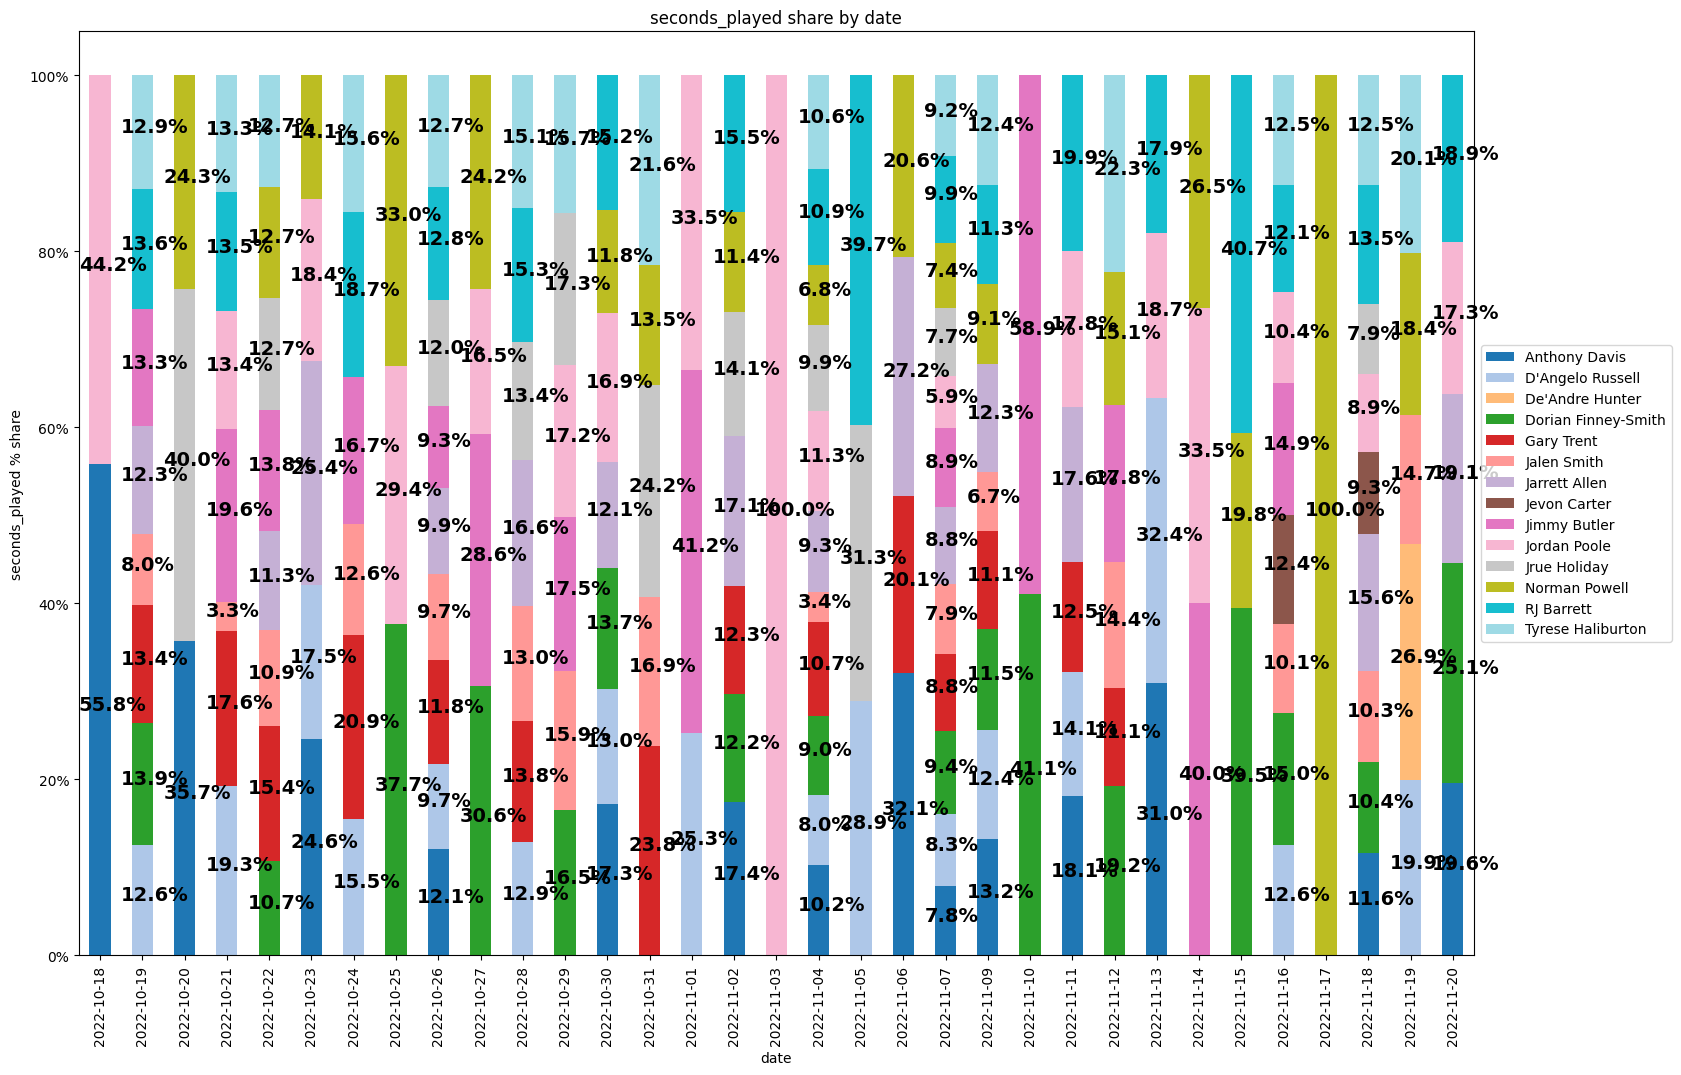

In [22]:
focus='seconds_played'
time_level='date'
ct=pd.crosstab(index=myteam_df[time_level], columns=myteam_df['name'], 
            values=myteam_df[focus].replace(np.NaN, 0), aggfunc='sum', 
            dropna=False, normalize='index') # margins=True, gets all
ct.plot(kind='bar',stacked=True,colormap='tab20', figsize=(18,12))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(f'{time_level}')
plt.ylabel(f'{focus} % share')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title(f'{focus} share by {time_level}')

threshold=0
for n, x in enumerate([*ct.index.values]):
    for (proportion, y_loc) in zip(ct.loc[x], ct.loc[x].cumsum()):
        if proportion>threshold:
            plt.text(x=n-0.5, y=(y_loc-proportion)+(proportion/2),
                    s=f'{np.round(proportion*100,1)}%',
                    color='black', fontsize=14, fontweight='bold')

plt.show()


## Share of contribution by week

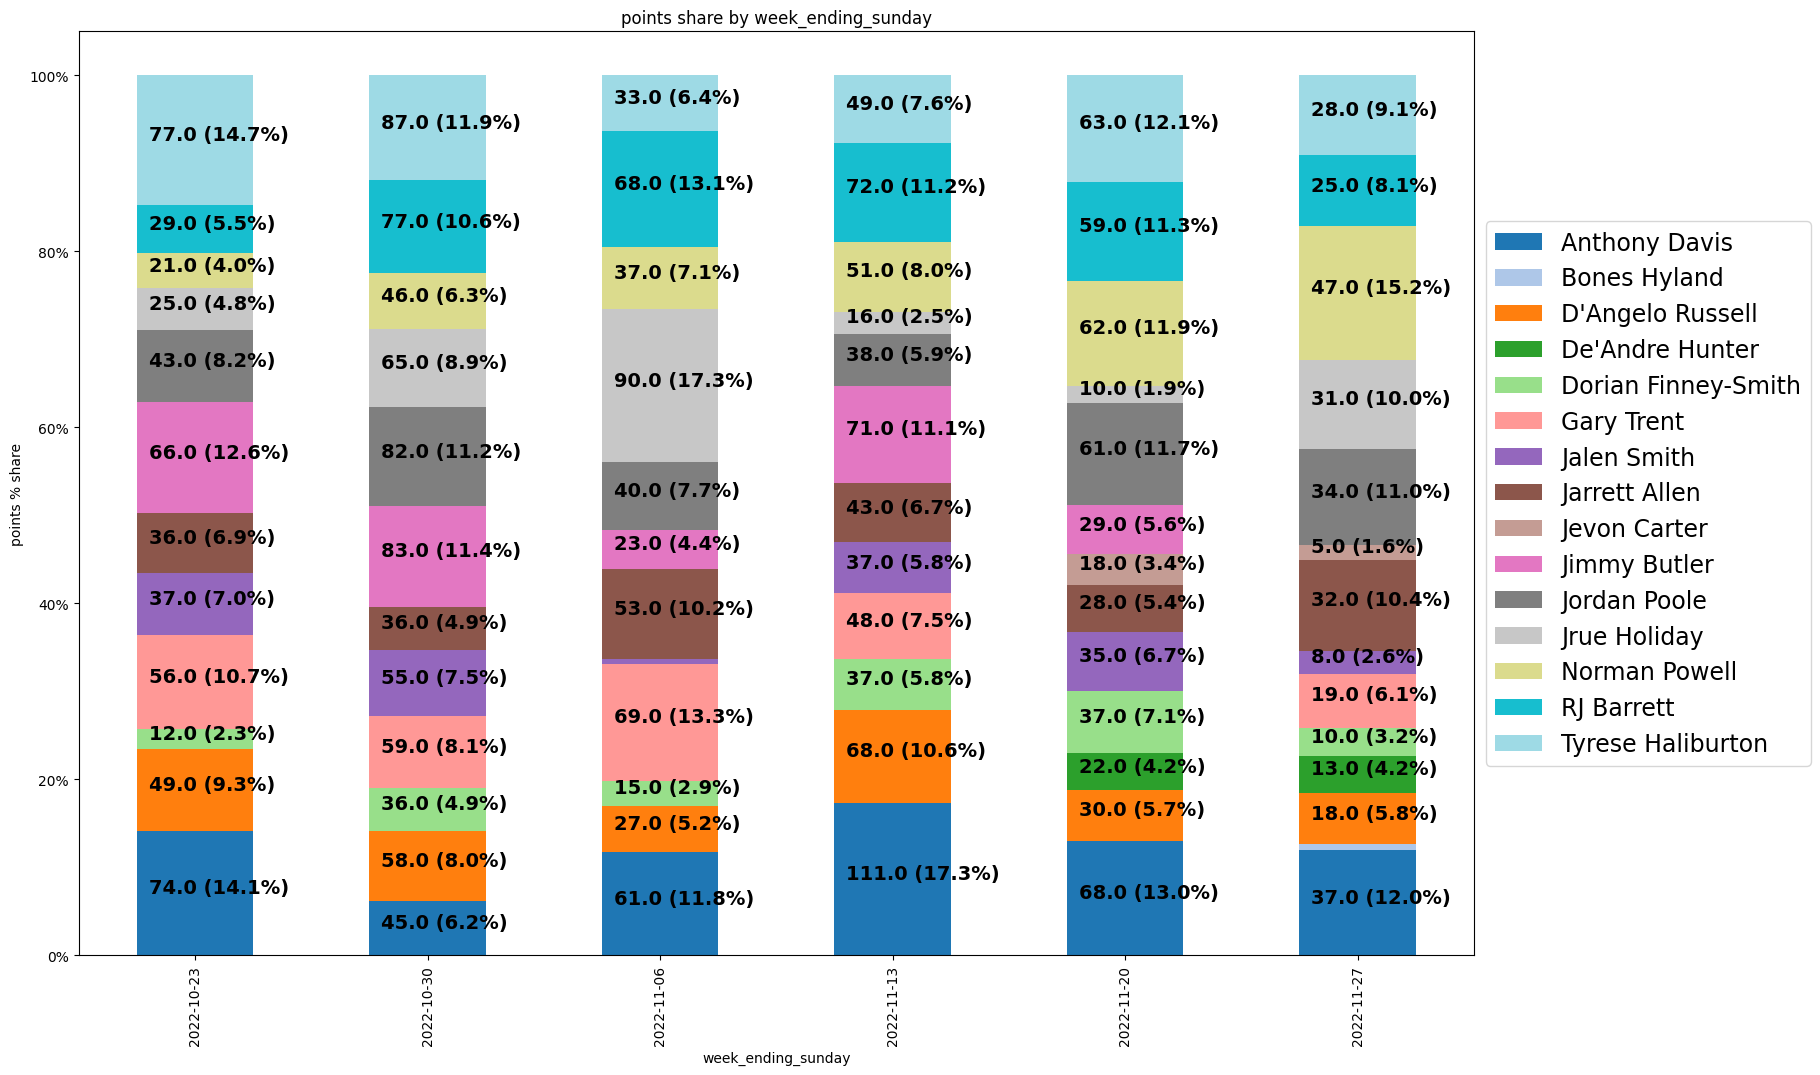

In [10]:
focus='points'
time_level='week_ending_sunday'
threshold=0.01

ctab=pd.crosstab(index=myteam_df[time_level], columns=myteam_df['name'], 
            values=myteam_df[focus].replace(np.NaN, 0), aggfunc='sum', 
            dropna=False) # margins=True, gets all

ct=pd.crosstab(index=myteam_df[time_level], columns=myteam_df['name'], 
            values=myteam_df[focus].replace(np.NaN, 0), aggfunc='sum', 
            dropna=False, normalize='index') # margins=True, gets all
ct.plot(kind='bar', stacked=True, colormap='tab20', figsize=(18,12))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':17})

plt.xlabel(f'{time_level}')
plt.ylabel(f'{focus} % share')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title(f'{focus} share by {time_level}')

for n, x in enumerate([*ct.index.values]):
    for (proportion, count, y_loc) in zip(ct.loc[x], ctab.loc[x], ct.loc[x].cumsum()):
        if proportion>threshold:
            plt.text(x=n-0.20, y=(y_loc-proportion)+(proportion/2),
                    s=f'{count} ({np.round(proportion*100,1)}%)',
                    color='black', fontsize=14, fontweight='bold')

plt.show()


## Player Metrics played over time
### *Note: Advised to use week-ending-date, since players do not necessarily have a game every day

### Count Evaluations

In [170]:
myteam_df.columns

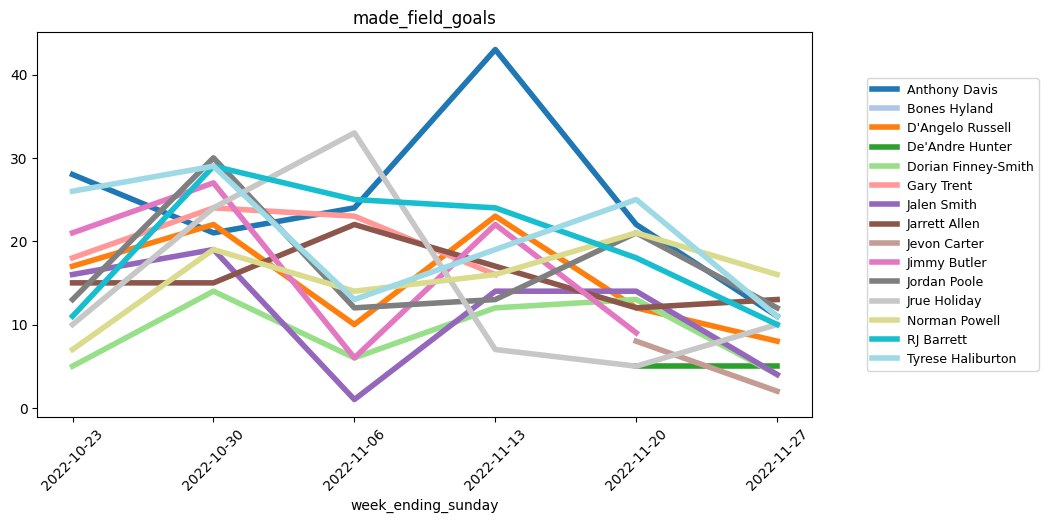

In [11]:
focus='made_field_goals'
time_level='week_ending_sunday'
xaxis=pd.date_range(min(myteam_df[time_level].unique()),max(myteam_df[time_level].unique()), freq='W')

ctab=pd.crosstab(index=myteam_df[time_level], columns=myteam_df['name'], 
            values=myteam_df[focus], aggfunc='sum', 
            dropna=False)
ctab.plot(kind='line', colormap='tab20', figsize=(10,5), linewidth=4)
plt.xticks(rotation=45)
plt.xticks(xaxis)
plt.title(focus)
plt.legend(loc='center right', bbox_to_anchor=(1.3,0.5), prop={'size':9})
plt.show()

## Efficiency Analysis 
### Player production rate given time played (ratios)

In [168]:
cols=['made_field_goals', 'attempted_field_goals',
       'made_three_point_field_goals', 'attempted_three_point_field_goals',
       'made_free_throws', 'attempted_free_throws', 'offensive_rebounds',
       'defensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers',
       'personal_fouls', 'game_score', 'points', 'total_rebounds', 'minutes_played', 
     'seconds_played']
time_level='week_ending_sunday'

df=myteam_df.groupby([time_level, 'name'])[cols].sum(numeric_only=True)
df=df.reset_index()
df['fg_pct']=df['made_field_goals']/df['attempted_field_goals']
df['3fg_pct']=df['made_three_point_field_goals']/df['attempted_three_point_field_goals']
df['ft_pct']=df['made_free_throws']/df['attempted_free_throws']
df['made_field_goals_per_minutes_played']=df['made_field_goals']/df['minutes_played']
df['made_three_point_field_per_minutes_played']=df['made_three_point_field_goals']/df['minutes_played']
df['made_free_throws_per_minutes_played']=df['made_free_throws']/df['minutes_played']
df['offensive_rebounds_goals_per_minutes_played']=df['offensive_rebounds']/df['minutes_played']
df['defensive_rebounds_per_minutes_played']=df['defensive_rebounds']/df['minutes_played']
df['assists_per_minutes_played']=df['assists']/df['minutes_played']
df['steals_per_minutes_played']=df['steals']/df['minutes_played']
df['blocks_per_minutes_played']=df['blocks']/df['minutes_played']
df['turnovers_per_minutes_played']=df['turnovers']/df['minutes_played']
df['personal_fouls_per_minutes_played']=df['personal_fouls']/df['minutes_played']
df['points_per_minutes_played']=df['points']/df['minutes_played']
df['total_rebounds_per_minutes_played']=df['total_rebounds']/df['minutes_played']

focus='points_per_minutes_played'
xaxis=pd.date_range(min(myteam_df[time_level].unique()),max(myteam_df[time_level].unique()), freq='W')

ctab=pd.crosstab(index=df[time_level], columns=df['name'], 
            values=df[focus], aggfunc=['sum'])

ctab.plot(kind='line', colormap='tab20', figsize=(10,5), linewidth=4)
plt.xticks(rotation=45)
plt.xticks(xaxis)
plt.title(focus)
plt.legend(loc='center right', bbox_to_anchor=(1.3,0.5), prop={'size':9})
plt.show()


## 

In [167]:
cols=['made_field_goals', 'made_three_point_field_goals','made_free_throws', 
      'total_rebounds', 'offensive_rebounds', 'defensive_rebounds', 'assists', 
      'steals', 'blocks', 'turnovers', 'personal_fouls', 'points', 'minutes_played',
      'made_field_goals_mp_weighted','made_three_point_field_goals_mp_weighted',
      'made_free_throws_mp_weighted', 'offensive_rebounds_mp_weighted',
      'defensive_rebounds_mp_weighted', 'assists_mp_weighted',
      'steals_mp_weighted', 'blocks_mp_weighted', 'turnovers_mp_weighted',
      'personal_fouls_mp_weighted', 'points_mp_weighted',
      'total_rebounds_mp_weighted'
     ]

focus_value='made_field_goals'
calc='mean'
player_sample=12
days_ago=7

def weighted_avg(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

today=dt.date.today()
days_back=today-dt.timedelta(days=days_ago)
calc_presentation='Standard Deviation' if calc=='std' else 'Average' if calc=='Mean' else 'Total'

sn.set(rc={'figure.figsize':(15,8)})

df_query=myteam_df.query("date >= @days_back")
# df_query=fa_df.query("date >= @days_back")
output=df_query.groupby(['name'])[cols].agg(calc).reset_index().sort_values(by=[focus_value],ascending=False).head(player_sample)
# output=df_query.groupby(['name'])[cols].agg().reset_index().sort_values(by=[focus_value],ascending=False).head(player_sample)

output.set_index(['name'], inplace=True, drop=True, append=False)
output.reset_index(inplace=False)
cmap='Spectral_r'
# output.iloc[:,1:len(output)-1] excluding names (obvious) but also exluding points due to scaling
# output.iloc[:,1:len(output)] includes points 
sn.heatmap(output.iloc[:,0:len(output)-1], annot=True, cmap=cmap)

plt.suptitle(f'Past {days_ago} day(s) - {calc_presentation} Analysis')
plt.title(f'{focus_value} leading')
plt.show()



In [166]:
val='points'
output=df_query.groupby(['name'])[cols].apply(weighted_avg, val, 'minutes_played').reset_index() #.sort_values(by=['total_rebounds'],ascending=False).head(player_sample)

output.columns=['name', 'weighted']
output.sort_values('weighted', ascending=False)

In [127]:
df_query=myteam_df.query("date >= @days_back")

In [165]:
df_query.head()

In [172]:
# sum(df_query['total_rebounds_mp_weighted'])/sum(df_query['minutes_played'])

In [164]:
bhl_df.head()

In [157]:
focus_val='assists'
agg=bhl_df.groupby(['team'])[focus_val].sum()
agg=pd.DataFrame(agg).reset_index()
agg.columns=['team', focus_val]
agg.sort_values(focus_val, ascending=False)

In [163]:
# ctab=pd.crosstab(index=df[time_level], columns=df['name'], 
#             values=df[focus], aggfunc=['sum'])

ctab=pd.crosstab(index=bhl_df['date'], columns=bhl_df['team'],
           values=bhl_df['made_field_goals'], aggfunc=['sum'])

ctab.plot(kind='line', colormap='tab20', figsize=(10,5), linewidth=4)
plt.xticks(rotation=45)
plt.xticks(xaxis)
plt.title(focus)
plt.legend(loc='center right', bbox_to_anchor=(1.3,0.5), prop={'size':9})
plt.show()


In [173]:
# myteam_df.head()
# adv_df.sort_values(['player_efficiency_rating'], ascending=False).head(20)
sorting_cols=['win_shares','win_shares_per_48_minutes']
names_display=sorting_cols.copy()
names_display.insert(0,'name')
filter_1=fa_adv_df['games_played']>=5
filter_2=fa_adv_df['offensive_win_shares']>0
filters=(filter_1) & (filter_2)
limit=15

fa_adv_df[filters][names_display].sort_values(by=sorting_cols, ascending=False).head(limit)
# fa_adv_df['games_played'].mean()



,name,win_shares,win_shares_per_48_minutes
76,De'Aaron Fox,1.900,0.207
185,Larry Nance Jr.,1.600,0.211
219,Nick Richards,1.500,0.200
153,Kevon Looney,1.500,0.175
269,Grant Williams,1.400,0.144
199,Onyeka Okongwu,1.300,0.190
255,Fred VanVleet,1.300,0.138
89,Josh Green,1.200,0.184
139,John Konchar,1.200,0.135
48,Torrey Craig,1.100,0.155


In [161]:
fa_adv_df.columns